In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline

In [2]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [3]:
PATH = Path("./MNIST")

In [4]:
device = "cuda:6" if torch.cuda.is_available() else "cpu"

In [5]:
tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
train_ds = datasets.MNIST(PATH, train=True, download=True, transform=tfms)
test_ds = datasets.MNIST(PATH, train=False, download=True, transform=tfms)

In [7]:
train_dl = data.DataLoader(train_ds, batch_size=64)
test_dl = data.DataLoader(test_ds, batch_size=64, shuffle=False)

In [8]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        
        
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        return x

In [9]:
class Classifier(nn.Module):
    def __init__(self, input_size, lr=1e-4, l2=0.):
        super().__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        self.loss_fn = F.nll_loss
    
    def forward(self, x):
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, pred, target):
        self._loss = self.loss_fn(pred, target)
        return self._loss

In [10]:
def train(epoch, model, train_loader):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        model.optim.zero_grad()
        output = model(data)
        loss = model.loss(output, target)
        loss.backward()
        model.optim.step()   
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss  {:.6f}'.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader), model._loss.item())
        print(line)
    return model._loss.item()

In [11]:
def test(model, loader, ds):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda l, c, p: ' ' + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            test_loss += model.loss(output, target).item() # sum up batch loss
            _, pred = torch.max(output.data, 1)
            correct += (pred == target).sum().item()
    
    test_loss /= test_size
    correct_pct = correct / test_size
    report = ''+ds+' set:\n' + line(test_loss, correct, 100.0 * correct_pct) + '\n'
    
    print(report)
    return test_loss, correct_pct

In [12]:
def plot_images(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [13]:
model = Classifier(28*28).to(device)

In [14]:
%%time
for epoch in range(1,21):
    model.train()
    train(epoch, model, train_dl)
    test(model, test_dl, 'Test')

Train Epoch: 1 [30016/60000 (100%)]	Loss  0.257721
Test set:
 Loss: 0.0057	Accuracy: 8929/10000 (89%)

Train Epoch: 2 [30016/60000 (100%)]	Loss  0.180254
Test set:
 Loss: 0.0047	Accuracy: 9090/10000 (91%)

Train Epoch: 3 [30016/60000 (100%)]	Loss  0.136390
Test set:
 Loss: 0.0042	Accuracy: 9191/10000 (92%)

Train Epoch: 4 [30016/60000 (100%)]	Loss  0.097583
Test set:
 Loss: 0.0038	Accuracy: 9266/10000 (93%)

Train Epoch: 5 [30016/60000 (100%)]	Loss  0.070055
Test set:
 Loss: 0.0034	Accuracy: 9337/10000 (93%)

Train Epoch: 6 [30016/60000 (100%)]	Loss  0.055572
Test set:
 Loss: 0.0031	Accuracy: 9400/10000 (94%)

Train Epoch: 7 [30016/60000 (100%)]	Loss  0.047917
Test set:
 Loss: 0.0028	Accuracy: 9456/10000 (95%)

Train Epoch: 8 [30016/60000 (100%)]	Loss  0.040790
Test set:
 Loss: 0.0026	Accuracy: 9499/10000 (95%)

Train Epoch: 9 [30016/60000 (100%)]	Loss  0.036456
Test set:
 Loss: 0.0024	Accuracy: 9531/10000 (95%)

Train Epoch: 10 [30016/60000 (100%)]	Loss  0.033529
Test set:
 Loss: 0.00

In [15]:
torch.save(model.state_dict(), PATH / "ae_classifier.model")

In [16]:
test_dl = data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [17]:
w, c = next(iter(test_dl))

### Original image

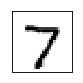

In [18]:
plot_images(w, (1,1))

### Class of original image

In [19]:
c.item()

7

In [20]:
class FitToClass(nn.Module):
    def __init__(self, data, target_class, clip_fn=None):
        super().__init__()
        self._loss = None
        self.target_class = torch.tensor([target_class]).to(device)
        self.w = nn.Parameter(data)
        self.clip_fn = clip_fn if clip_fn else lambda x: x
        self.optim = optim.Adam(self.parameters(), lr=1e-3)
        
    def forward(self):
        out = model(self.clip_fn(self.w))
        return out
    
    def loss(self, out):
        self._loss = F.nll_loss(out, self.target_class)
        return self._loss

### Try to change class of image to 8

In [21]:
line = lambda ms, ls: [f"{m}" for m, l in zip(ms,ls)]

model.eval()

models = {
    'no_clip': FitToClass(w, 8),
    'sigmoid': FitToClass(w, 8, F.sigmoid),
    'tanh': FitToClass(w, 8, F.tanh)
}

for m in models:
    models[m].to(device).train()

for i in range(1, 20_001):
    losses = [0.0]*len(models)
    for j , m in enumerate(models.values()):
        m.optim.zero_grad()
        out = m()
        loss = m.loss(out)
        loss.backward()
        m.optim.step()
        losses[j]+=loss.item()
    if i % 1000 == 0:
        s = [f"\t{m} = {losses[j]/1000.}\n" for j , m in enumerate(models)]
        line = f"{int(i/1000)}K iteration loss: \n{' '.join(s)}"
        print(line)
        losses = [0.0]*len(models)
            

1K iteration loss: 
	no_clip = 9.120941162109375e-06
 	sigmoid = 0.0004661533832550049
 	tanh = 2.6187896728515626e-05

2K iteration loss: 
	no_clip = 3.1747817993164064e-06
 	sigmoid = 0.00012169480323791504
 	tanh = 8.226394653320312e-06

3K iteration loss: 
	no_clip = 1.5106201171875e-06
 	sigmoid = 4.843616485595703e-05
 	tanh = 3.7903785705566406e-06

4K iteration loss: 
	no_clip = 8.440017700195313e-07
 	sigmoid = 2.5610923767089844e-05
 	tanh = 1.7504692077636718e-06

5K iteration loss: 
	no_clip = 4.92095947265625e-07
 	sigmoid = 1.5764713287353516e-05
 	tanh = 9.331703186035157e-07

6K iteration loss: 
	no_clip = 2.9277801513671875e-07
 	sigmoid = 1.0411739349365235e-05
 	tanh = 5.540847778320312e-07

7K iteration loss: 
	no_clip = 1.7642974853515625e-07
 	sigmoid = 7.154464721679687e-06
 	tanh = 3.4046173095703123e-07

8K iteration loss: 
	no_clip = 1.0395050048828125e-07
 	sigmoid = 5.005836486816406e-06
 	tanh = 2.1076202392578125e-07

9K iteration loss: 
	no_clip = 5.72204

In [22]:
target_imgs = {k: m.w.detach() for k, m in models.items()}
target_imgs['original']=w.to(device)

### Predict class of target image with trained classifier

In [23]:
{k: torch.argmax(model(target_img)).item() for k, target_img in target_imgs.items()}

{'no_clip': 8, 'sigmoid': 8, 'tanh': 8, 'original': 7}

### Plot target image

original


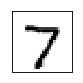

In [24]:
print('original')
plot_images(target_imgs['original'].view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

no_clip


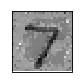

In [25]:
print('no_clip')
plot_images(target_imgs['no_clip'].view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

sigmoid


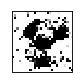

In [26]:
print('sigmoid')
plot_images(F.sigmoid(target_imgs['sigmoid']).view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

tanh


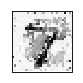

In [27]:
print('tanh')
plot_images(F.tanh(target_imgs['tanh']).view(-1, 1, 28, 28).data.cpu().numpy(), (1,1))

In [28]:
{k: target_img.mean().item() for k, target_img in target_imgs.items()}

{'no_clip': -0.9013300538063049,
 'sigmoid': -1.9802205562591553,
 'tanh': -0.8918442130088806,
 'original': -0.815386176109314}

In [29]:
{k: target_img.std().item() for k, target_img in target_imgs.items()}

{'no_clip': 0.654685378074646,
 'sigmoid': 4.2175421714782715,
 'tanh': 0.7728224992752075,
 'original': 0.5178234577178955}